# Simulated Change-Point Detection in Poisson Count Data: A Physics-Inspired Approach

### Approach
Simulating a photon count stream using a Poisson process with change-points (i.e., sudden intensity changes), and implementing change-point detection algorithms to detect those changes.

In [2]:
!pip install ruptures

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.7 MB/s eta 0:00:00


In [3]:
# Loading libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ruptures as rpt

In [12]:
np.random.seed(42)

In [13]:
# Simulating a time series of Poisson photon counts with sudden rate changes.
def simulate_poisson_counts(length=500, rates=[5, 20, 5], change_points=[150, 350]):
    times = np.arange(length)
    counts = []
    current = 0

    for i, rate in enumerate(rates):
        next_cp = change_points[i] if i < len(change_points) else length
        segment = np.random.poisson(rate, next_cp - current)
        counts.extend(segment)
        current = next_cp

    return np.array(times), np.array(counts)


In [14]:
# Detecting change points based on simple z-score in a sliding window
def detect_change_points(counts, window_size=20, threshold=3.0):
    change_points = []
    for t in range(window_size, len(counts) - window_size):
        left = counts[t - window_size:t]
        right = counts[t:t + window_size]
        mean_diff = np.abs(np.mean(right) - np.mean(left))
        pooled_std = np.sqrt(np.var(left) + np.var(right))

        if pooled_std == 0:
            continue

        z_score = mean_diff / pooled_std

        if z_score > threshold:
            change_points.append(t)

    return change_points


In [15]:
# Simulate data
times, counts = simulate_poisson_counts()

In [16]:
detected_cps = detect_change_points(counts)

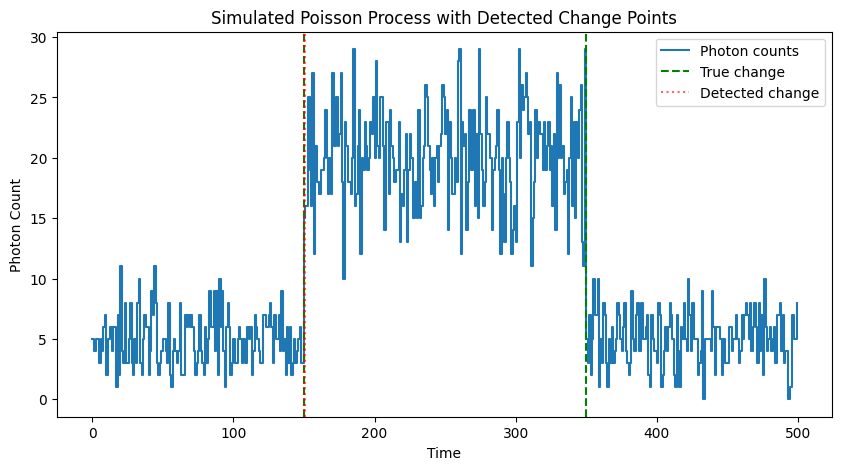

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(times, counts, drawstyle='steps-post', label='Photon counts')
plt.title("Simulated Poisson Process with Detected Change Points")
plt.xlabel("Time")
plt.ylabel("Photon Count")

for cp in [150, 350]:
    plt.axvline(cp, color='green', linestyle='--', label='True change' if cp == 150 else "")

# Detected change points
for dcp in detected_cps:
    plt.axvline(dcp, color='red', linestyle=':', alpha=0.6, label='Detected change' if dcp == detected_cps[0] else "")

plt.legend()
plt.show()

The algorithm detects the change points at time t = 150, but has missed the change points at time t = 350. We can try increasing the window size to see if this helps improve detection.

In [18]:
detected_cps = detect_change_points(counts, window_size=40)

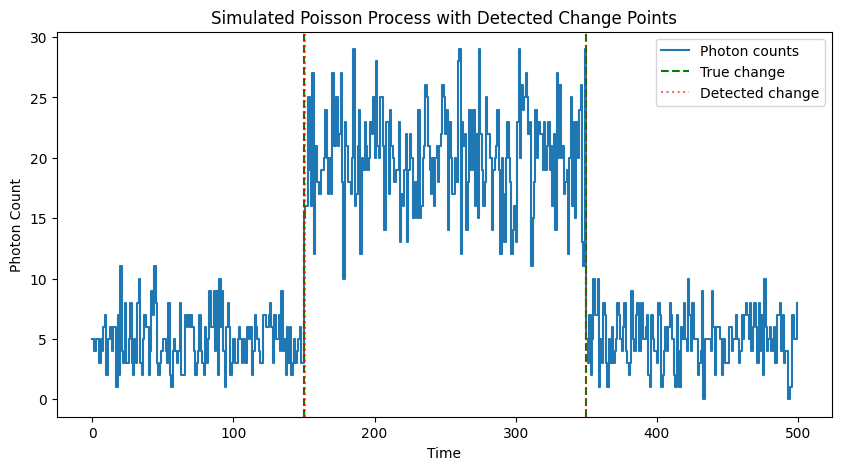

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(times, counts, drawstyle='steps-post', label='Photon counts')
plt.title("Simulated Poisson Process with Detected Change Points")
plt.xlabel("Time")
plt.ylabel("Photon Count")

for cp in [150, 350]:
    plt.axvline(cp, color='green', linestyle='--', label='True change' if cp == 150 else "")

# Detected change points
for dcp in detected_cps:
    plt.axvline(dcp, color='red', linestyle=':', alpha=0.6, label='Detected change' if dcp == detected_cps[0] else "")

plt.legend()
plt.show()

The algorithm has successfully detected change points at both t = 150, and t = 350. For the sake of experimentation, I will try it this again with a window_size = 30 (in between 20 and 40), as well as a different threshold value for the z-score (change-points will be detected for z-score < 2)

In [20]:
detected_cps = detect_change_points(counts, window_size=30, threshold=2.0)

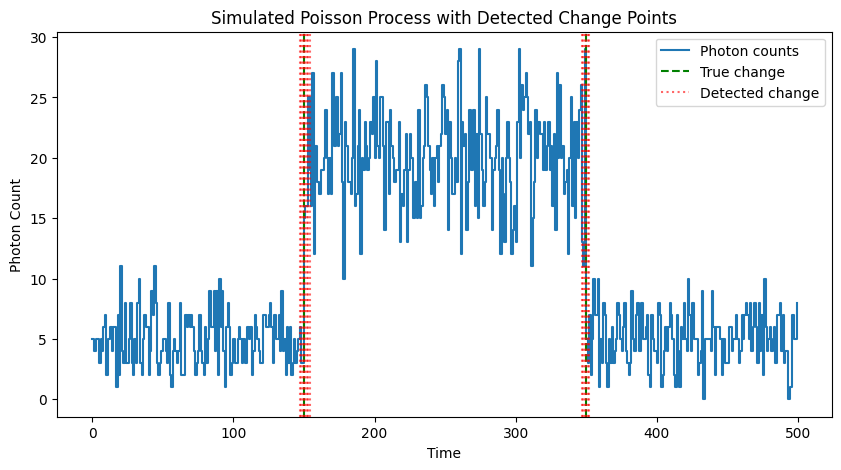

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(times, counts, drawstyle='steps-post', label='Photon counts')
plt.title("Simulated Poisson Process with Detected Change Points")
plt.xlabel("Time")
plt.ylabel("Photon Count")

for cp in [150, 350]:
    plt.axvline(cp, color='green', linestyle='--', label='True change' if cp == 150 else "")

# Detected change points
for dcp in detected_cps:
    plt.axvline(dcp, color='red', linestyle=':', alpha=0.6, label='Detected change' if dcp == detected_cps[0] else "")

plt.legend()
plt.show()


This gives us a dense cluster of detected change points around both locations, likely due to the lower threshold (2.0) and the window size (30) catching the signal strongly. We can create a new function which finds the mean of the clustered points and graphs only the mean of the points.

In [22]:
def cluster_change_points(change_points, tolerance=10):
    clustered = []
    current_cluster = [change_points[0]]

    for pt in change_points[1:]:
        if pt - current_cluster[-1] <= tolerance:
            current_cluster.append(pt)
        else:
            clustered.append(int(np.mean(current_cluster)))
            current_cluster = [pt]

    clustered.append(int(np.mean(current_cluster)))
    return clustered

In [23]:
raw_detections = detect_change_points(counts, window_size=30, threshold=2.0)
final_detections = cluster_change_points(raw_detections, tolerance=10)

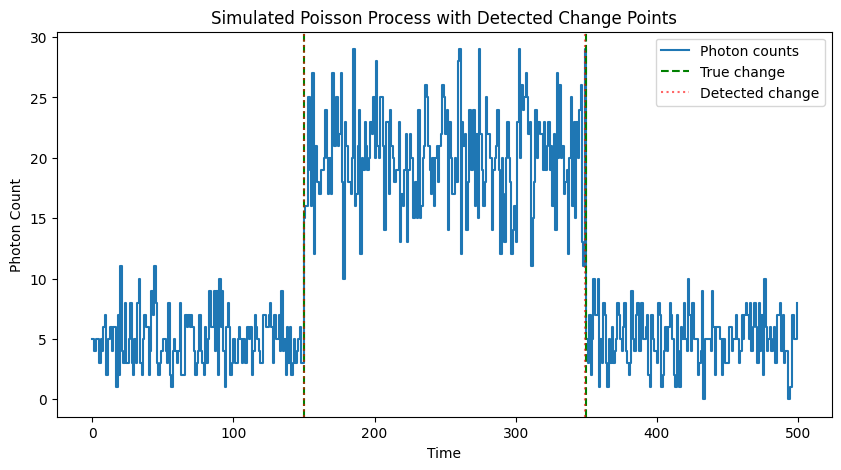

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(times, counts, drawstyle='steps-post', label='Photon counts')
plt.title("Simulated Poisson Process with Detected Change Points")
plt.xlabel("Time")
plt.ylabel("Photon Count")

for cp in [150, 350]:
    plt.axvline(cp, color='green', linestyle='--', label='True change' if cp == 150 else "")

# Detected change points
for dcp in final_detections:
    plt.axvline(dcp, color='red', linestyle=':', alpha=0.6, label='Detected change' if dcp == final_detections[0] else "")

plt.legend()
plt.show()

In [25]:
# Calculating the Precision, Recall and F1 score of the detections
def evaluate_detections(true_points, detected_points, tolerance=10):
    true_positives = sum(any(abs(tp - dp) <= tolerance for dp in detected_points) for tp in true_points)
    false_positives = sum(all(abs(dp - tp) > tolerance for tp in true_points) for dp in detected_points)
    false_negatives = len(true_points) - true_positives

    precision = true_positives / (true_positives + false_positives + 1e-8)
    recall = true_positives / (true_positives + false_negatives + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)

    return precision, recall, f1

In [26]:
evaluate_detections([150, 350], final_detections)

(0.999999995, 0.999999995, 0.9999999900000001)

## Real-World Example
Using climate data such as temperature and rainfall to test whether our algorithm works on real world data

In [27]:
from google.colab import files
uploaded = files.upload()

Saving london_weather.csv to london_weather.csv


In [28]:

df = pd.read_csv('london_weather.csv')
df.head()


,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15341 entries, 0 to 15340
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              15341 non-null  int64  
 1   cloud_cover       15322 non-null  float64
 2   sunshine          15341 non-null  float64
 3   global_radiation  15322 non-null  float64
 4   max_temp          15335 non-null  float64
 5   mean_temp         15305 non-null  float64
 6   min_temp          15339 non-null  float64
 7   precipitation     15335 non-null  float64
 8   pressure          15337 non-null  float64
 9   snow_depth        13900 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 1.2 MB


In [30]:
df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")
df = df.sort_values("date")
df = df[["date", "mean_temp", "precipitation"]]

In [31]:
df.head()

,date,mean_temp,precipitation
0,1979-01-01,-4.1,0.4
1,1979-01-02,-2.6,0.0
2,1979-01-03,-2.8,0.0
3,1979-01-04,-2.6,0.0
4,1979-01-05,-0.8,0.0


In [32]:
mean_temp_series = df["mean_temp"].values
precip_series = df["precipitation"].values

change_points_temp = detect_change_points(mean_temp_series, window_size=30, threshold=2)
change_points_precip = detect_change_points(precip_series, window_size=30, threshold=2)

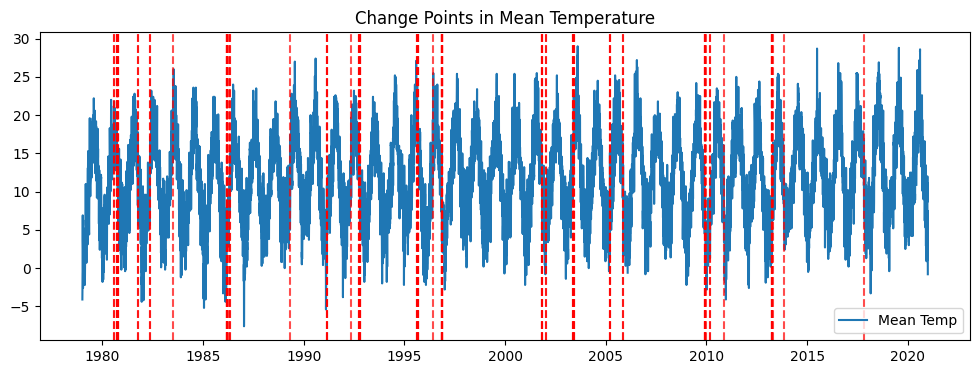

In [35]:
plt.figure(figsize=(12, 4))
plt.plot(df["date"], mean_temp_series, label="Mean Temp")
for cp in change_points_temp:
    plt.axvline(df["date"].iloc[cp], color="red", linestyle="--", alpha=0.7)
plt.title("Change Points in Mean Temperature")
plt.legend()
plt.show()

Using the window_size (30) and threshold (2.0) which was the most sensitive to the change points, we get various detected change points indicating the transition of seasons over years. However, the algorithm also misses several of them.

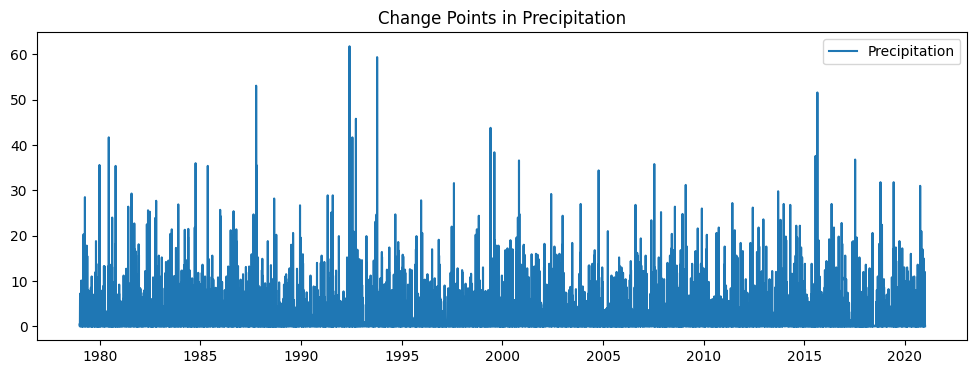

In [36]:
plt.figure(figsize=(12, 4))
plt.plot(df["date"], precip_series, label="Precipitation")
for cp in change_points_precip:
    plt.axvline(df["date"].iloc[cp], color="red", linestyle="--", alpha=0.7)
plt.title("Change Points in Precipitation")
plt.legend()
plt.show()

No change points detected in the preciptation data. We can try using an existing library like ruptures to see whether we get different results

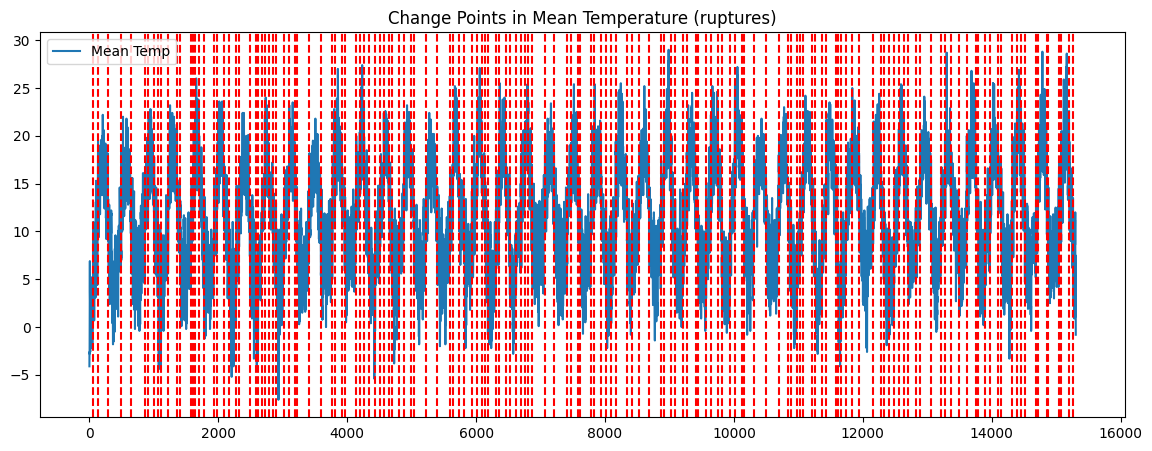

In [37]:
series = df[['mean_temp']].dropna().reset_index(drop=True)
signal = series['mean_temp'].values

# Change point detection: Pelt method with 'rbf' cost (good for shifts in mean & variance)
model = rpt.Pelt(model="rbf").fit(signal)

# Adjust penalty to control sensitivity (higher = fewer changes)
change_points = model.predict(pen=10)

# Visualize
plt.figure(figsize=(14, 5))
plt.plot(series['mean_temp'].values, label="Mean Temp")
for cp in change_points[:-1]:  # exclude final point
    plt.axvline(x=cp, color='red', linestyle='--')
plt.title("Change Points in Mean Temperature (ruptures)")
plt.legend()
plt.show()

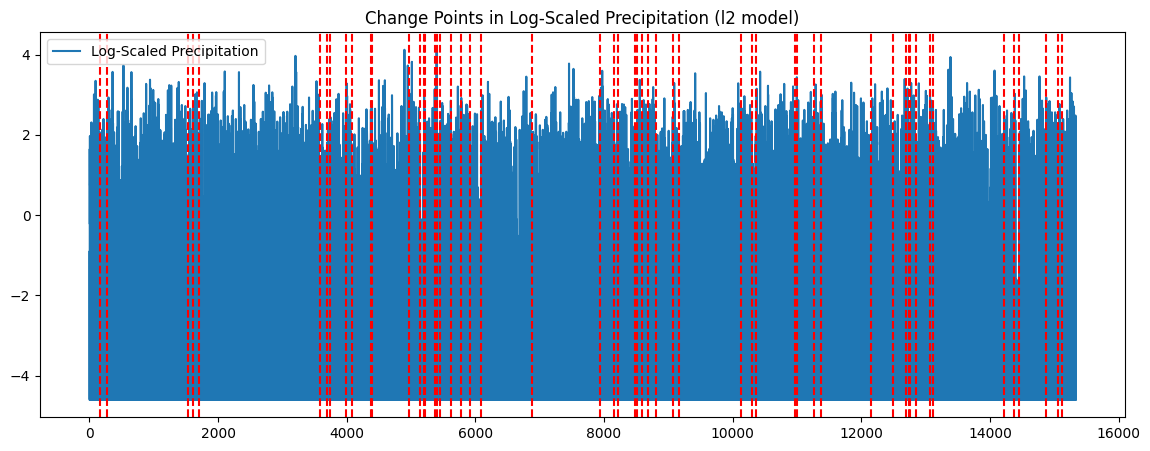

In [43]:
precip = df['precipitation'].dropna().reset_index(drop=True)
precip = precip.replace(0, 0.01)
log_precip = np.log(precip.values).reshape(-1, 1)

# Apply faster model
model = rpt.Pelt(model="l2").fit(log_precip)
change_points = model.predict(pen=100)

# Plotting
plt.figure(figsize=(14, 5))
plt.plot(log_precip, label="Log-Scaled Precipitation")
for cp in change_points[:-1]:
    plt.axvline(x=cp, color='red', linestyle='--')
plt.title("Change Points in Log-Scaled Precipitation (l2 model)")
plt.legend()
plt.show()
